# Customer Lifetime Value Analysis

The marketing team at wants to know how much can they spend on acquiring new customers to the platform. Therefore,they need CLV Analysis on an all customers for theor entire customer relation duration.

In [1]:
import DataPipeline as dp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8-talk")

## Initialize Data pipeline

In [2]:
pipeline = dp.DataPipeline()

18:37:53 Initializing pipeline
18:37:53 Creating customer cohorts view in database
18:37:53 Creating top partners by sales view in database
18:37:53 Creating partner segments and order quantity view in database
18:37:53 Done


## Retention Rate Analysis

In [3]:
query = """ 
            SELECT 
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                (CAST( COUNT(MONTHS_SINCE_FIRST_PURCHASE) AS REAL) / 
                CAST((SELECT COUNT(DISTINCT(USERID)) FROM CUSTOMER_COHORT) AS REAL))*100 AS RETENTION_RATE,
                COUNT(MONTHS_SINCE_FIRST_PURCHASE) as CUSTOMER_COUNT
            FROM CUSTOMER_COHORT
            GROUP BY MONTHS_SINCE_FIRST_PURCHASE
        """
retention_rate = pipeline.execute_query(query=query)

In [4]:
retention_rate

,M,RETENTION_RATE,CUSTOMER_COUNT
0,0,100.000000,123208
1,1,14.587527,17973
2,2,12.001656,14787
3,3,10.594280,13053
4,4,9.544835,11760
5,5,8.895526,10960
6,6,7.850140,9672
7,7,7.306344,9002
8,8,6.209012,7650
9,9,5.468801,6738


### Ploting retention curve

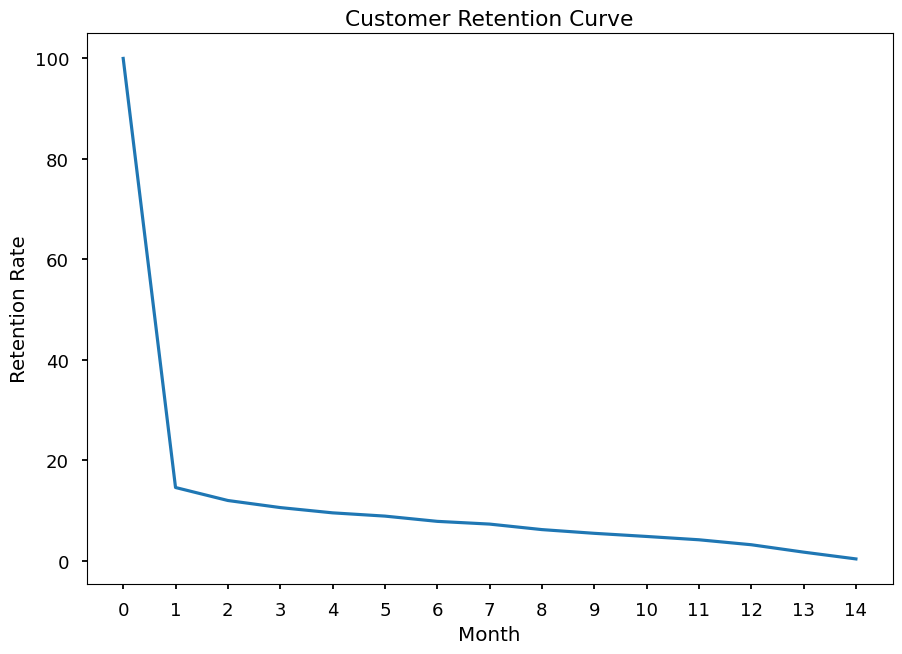

In [5]:
plt.plot(retention_rate.M,  retention_rate.RETENTION_RATE)
plt.title("Customer Retention Curve")
plt.ylabel("Retention Rate")
plt.xlabel("Month")
plt.xticks(ticks=retention_rate.M)
plt.show()

#### Inference

- The customer base is **123,208**. These customers are users who have purchased at least once.
- Out of this customer base, the M1 retention rate is **14.59%**. This means that **14.59% of customers (17,973)** return to purchase again one month after their first purchase. Conversely, **more than 80% of customers** do not return to purchase in the first month after their first purchase. Customers **could be encouraged to continue purchasing** after their first purchase, perhaps through discounts for subsequent months, and impproved customer experience.
- The maximum customer lifetime is **14 months**.

## Cohort Analysis

In [6]:
query= """
        SELECT 
                USERID,
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                COHORT_DATE as cohort
        FROM CUSTOMER_COHORT
      """

cohorts_df = pipeline.execute_query(query=query)

cohorts_df = (
    cohorts_df.groupby(["cohort", "M"])[["USERID"]]
    .nunique()
    .assign(
        total=lambda x: x.groupby("cohort")[["USERID"]].transform(lambda x: x.iloc[0]),
        retention=lambda x: 100 * x.USERID / x.total,
    )
    .reset_index()
)

cohorts_df.rename(columns={"USERID": "customer_count"}, inplace=True)

In [7]:
cohorts_df

,cohort,M,customer_count,total,retention
0,2022-09-01,0,4134,4134,100.000000
1,2022-09-01,1,1220,4134,29.511369
2,2022-09-01,2,1090,4134,26.366715
3,2022-09-01,3,849,4134,20.537010
4,2022-09-01,4,898,4134,21.722303
...,...,...,...,...,...
115,2023-09-01,1,903,7502,12.036790
116,2023-09-01,2,474,7502,6.318315
117,2023-10-01,0,7123,7123,100.000000
118,2023-10-01,1,531,7123,7.454724


In [8]:
cohorts_pivot = cohorts_df[['cohort','M','retention']].pivot(columns='M',index='cohort')['retention']

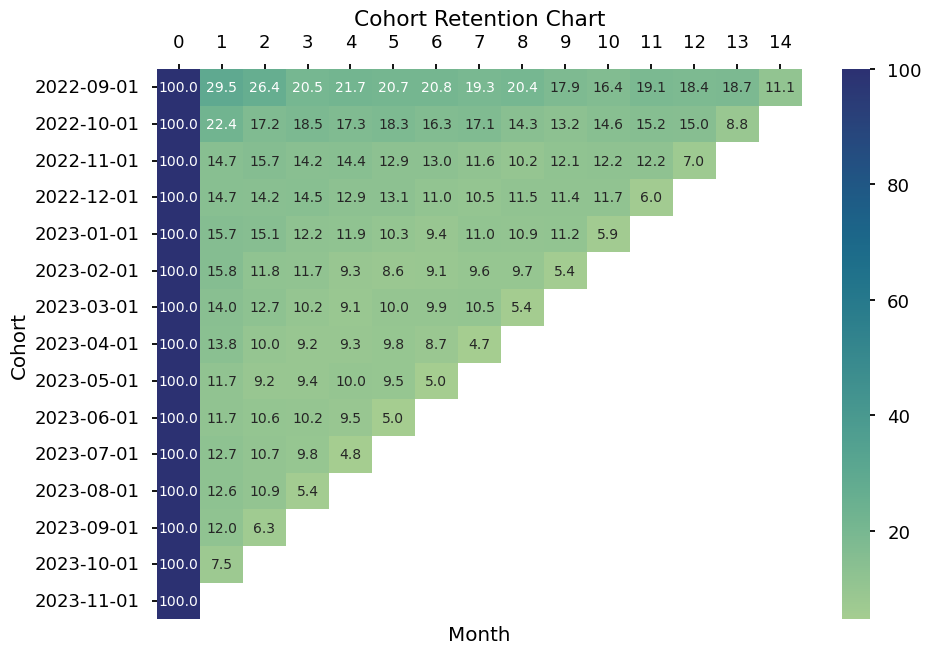

In [9]:
g= sns.heatmap(
    cohorts_pivot,
    cmap='crest',
    annot= True,
    fmt='.1f'
)
g.axes.xaxis.set_ticks_position("top")
plt.title("Cohort Retention Chart")
plt.xlabel("Month")
plt.ylabel("Cohort")
plt.show()

#### Inference

- Retention is sustained after M1. It is crucial to reduce the drop after M0 to increase the likelihood of retaining customers for greater revenue.
- The cohort from **September 2022** (2022-09) is the most retained cohort, with retention sustained around **20%** up to M9 (the tenth month).
- There was a drop in retention in **December** for the 2022-09 and 2022-10 cohorts. In December, the 2022-09 cohort dropped by about **6%**, and the 2022-10 cohort dropped by about **3%**.
- There is a noticeable **4-7% drop** in retention during **November** across all cohorts (see diagonal from cohort 2023-10, M1 to cohort 2022-09, M14). What happens in November? The company could consider strategies such as discounted sales or special offers in October, November, and December to sustain or boost retention.
- An increase in retention is observable during the **fall months** (August, September, October). The company could capitalize on this opportunity to boost sales during these months.